# Import 

In [214]:
import numpy as np
import mido
import midi_video
from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt

from pretty_midi import PrettyMIDI
from pypianoroll import Track, Multitrack

# Utils 

In [7]:
from mido import MidiFile, MidiTrack, Message

num_notes = 96
samples_per_measure = 96
midi_path = './Despicable.mid'

def midi_to_samples(fname):
    has_time_sig = False
    flag_warning = False
    mid = MidiFile(fname)
    ticks_per_beat = mid.ticks_per_beat
    ticks_per_measure = 4 * ticks_per_beat

    for i, track in enumerate(mid.tracks):
        for msg in track:
            if msg.type == 'time_signature':
                print(msg.numerator)
                new_tpm = msg.numerator * ticks_per_beat * 4 / msg.denominator
                if has_time_sig and new_tpm != ticks_per_measure:
                    flag_warning = True
                ticks_per_measure = new_tpm
                has_time_sig = True
    if flag_warning:
        print("  ^^^^^^ WARNING ^^^^^^")
        print("    " + fname)
        print("    Detected multiple distinct time signatures.")
        print("  ^^^^^^ WARNING ^^^^^^")
        return []
    
    all_notes = {}
    for i, track in enumerate(mid.tracks):
        abs_time = 0
        for msg in track:
            abs_time += msg.time
            if msg.type == 'note_on':
                if msg.velocity == 0:
                    continue
                note = msg.note - (128 - num_notes)/2
                assert(note >= 0 and note < num_notes)
                if note not in all_notes:
                    all_notes[note] = []
                else:
                    single_note = all_notes[note][-1]
                    if len(single_note) == 1:
                        single_note.append(single_note[0] + 1)
                all_notes[note].append([abs_time * samples_per_measure / ticks_per_measure])
            elif msg.type == 'note_off':
                if len(all_notes[note][-1]) != 1:
                    continue
                all_notes[note][-1].append(abs_time * samples_per_measure / ticks_per_measure)
    for note in all_notes:
        for start_end in all_notes[note]:
            if len(start_end) == 1:
                start_end.append(start_end[0] + 1)
    samples = []
    for note in all_notes:
        for start, end in all_notes[note]:
            sample_ix = start / samples_per_measure
            while len(samples) <= sample_ix:
                samples.append(np.zeros((samples_per_measure, num_notes), dtype=np.uint8))
            sample = samples[sample_ix]
            start_ix = start - sample_ix * samples_per_measure
            if False:
                end_ix = min(end - sample_ix * samples_per_measure, samples_per_measure)
                while start_ix < end_ix:
                    sample[start_ix, note] = 1
                    start_ix += 1
            else:
                sample[start_ix, note] = 1
    return samples

def samples_to_midi(samples, fname, ticks_per_sample, thresh=0.5):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    ticks_per_beat = mid.ticks_per_beat
    ticks_per_measure = 4 * ticks_per_beat
    ticks_per_sample = ticks_per_measure / samples_per_measure
    abs_time = 0
    last_time = 0
    for sample in samples:
        for y in xrange(sample.shape[0]):
            abs_time += ticks_per_sample
            for x in xrange(sample.shape[1]):
                note = x + (128 - num_notes)/2
                if sample[y,x] >= thresh and (y == 0 or sample[y-1,x] < thresh):
                    delta_time = abs_time - last_time
                    track.append(Message('note_on', note=note, velocity=127, time=delta_time))
                    last_time = abs_time
                if sample[y,x] >= thresh and (y == sample.shape[0]-1 or sample[y+1,x] < thresh):
                    delta_time = abs_time - last_time
                    track.append(Message('note_off', note=note, velocity=127, time=delta_time))
                    last_time = abs_time
    mid.save(fname)

# Load Midi 

In [71]:
mid = mido.MidiFile('./Des.MID')

In [22]:
def midi_to_samples(fname):
    mid = MidiFile(fname)
    ticks_per_beat = mid.ticks_per_beat
    
    # delete
    ticks_per_measure = 4 * ticks_per_beat

    all_notes = {}
    
    for i, track in enumerate(mid.tracks):
        abs_time = 0
        for msg in track:
            abs_time += msg.time
#             print(msg)
            if msg.type == 'note_on':
                if msg.velocity == 0:
                    print("zero vel wtf", msg)
                    continue
                # Робить ноту нижче на 16 втф?
                note = msg.note - (128 - num_notes)/2
                assert(note >= 0 and note < num_notes)
                
                if note not in all_notes:
                    all_notes[note] = []
                else:
                    single_note = all_notes[note][-1]
                    if len(single_note) == 1:
                        single_note.append(single_note[0] + 1)
                all_notes[note].append([abs_time * samples_per_measure / ticks_per_measure])
            elif msg.type == 'note_off':
                if len(all_notes[note][-1]) != 1:
                    continue
                all_notes[note][-1].append(abs_time * samples_per_measure / ticks_per_measure)

    for note in all_notes:
        for start_end in all_notes[note]:
            if len(start_end) == 1:
                start_end.append(start_end[0] + 1)
#     samples = []
#     for note in all_notes:
#         for start, end in all_notes[note]:
#             sample_ix = start / samples_per_measure
#             while len(samples) <= sample_ix:
#                 samples.append(np.zeros((samples_per_measure, num_notes), dtype=np.uint8))
#             sample = samples[sample_ix]
#             start_ix = start - sample_ix * samples_per_measure
#             if False:
#                 end_ix = min(end - sample_ix * samples_per_measure, samples_per_measure)
#                 while start_ix < end_ix:
#                     sample[start_ix, note] = 1
#                     start_ix += 1
#             else:
#                 sample[start_ix, note] = 1
    return all_notes#samples

mid = midi_to_samples(midi_path)

In [3]:
mid = PrettyMIDI('./Des.MID')

In [4]:
np.max(mid.instruments[0].get_piano_roll())

0.0

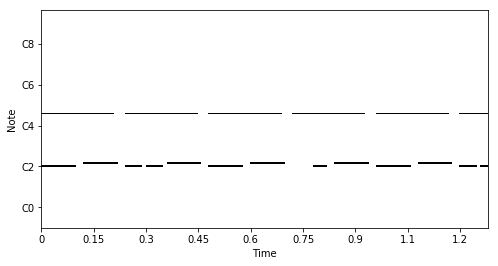

In [285]:
import librosa.display
import pretty_midi

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.pianoroll[start_pitch:end_pitch].T,
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(track, 0, 128)

In [144]:
np.unique(track.pianoroll)

array([ 0, 72], dtype=uint8)

In [140]:
def load_midi_map(file_path):
    res = {}
    with open(file_path, 'r') as f:
        for line in f:
            midi_id = re.search(r'\d+', line).group(0)
            drum_name = line.replace(midi_id, '').strip()
            res[int(midi_id)] = drum_name
    return res

def note_gen(track):
    for i in range(track.pianoroll.shape[0]):
        notes = track.pianoroll[i]
        hits = np.where(notes != 0)
        if np.sum(notes) != 0:
            yield i, hits

def notes_used_in_track(track, midi_map=None):   
    notes = np.hstack([note for _, note in note_gen(track)])
    
    if midi_map is None:
        return np.unique(notes)
    else:
        res = {}
        for i in np.unique(notes):
            res[i] = midi_map[i]
        return res

midi_map = load_midi_map('./midi_map.txt')

notes_used_in_track(track, midi_map)

{36: 'Kick',
 38: 'Snare Open Hit L',
 43: 'Snare Shallow Hit',
 45: 'Ride Pearl (double)',
 46: 'Cymbal 1 (double)',
 47: 'Cowbell - Mid Tom',
 48: 'HH Pedal Closed',
 49: 'HH Closed 1 Pearl',
 50: 'HH Closed 1 Shaft',
 51: 'HH Closed 2 Pearl',
 52: 'HH Closed 2 Shaft',
 55: 'HH Open B'}

In [139]:
pm = mid.to_pretty_midi()
for note in pm.instruments[0].notes:
    if note.pitch == 47:
        print(note)

Note(start=15.600000, end=15.612500, pitch=47, velocity=100)
Note(start=16.500000, end=16.512500, pitch=47, velocity=100)
Note(start=45.750000, end=45.762500, pitch=47, velocity=100)
Note(start=54.900000, end=54.912500, pitch=47, velocity=100)
Note(start=55.050000, end=55.062500, pitch=47, velocity=100)
Note(start=55.350000, end=55.362500, pitch=47, velocity=100)
Note(start=75.450000, end=75.462500, pitch=47, velocity=100)
Note(start=75.525000, end=75.537500, pitch=47, velocity=100)
Note(start=75.900000, end=75.912500, pitch=47, velocity=100)
Note(start=76.050000, end=76.062500, pitch=47, velocity=100)
Note(start=76.650000, end=76.662500, pitch=47, velocity=100)
Note(start=114.000000, end=114.012500, pitch=47, velocity=100)
Note(start=114.150000, end=114.162500, pitch=47, velocity=100)
Note(start=116.850000, end=116.862500, pitch=47, velocity=100)
Note(start=117.750000, end=117.762500, pitch=47, velocity=100)
Note(start=118.950000, end=118.962500, pitch=47, velocity=100)
Note(start=126

(24, 80)

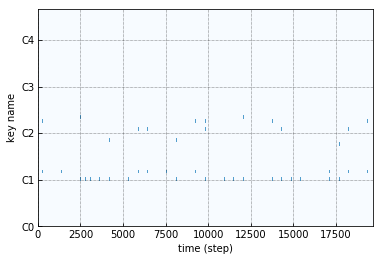

In [5]:
mid = Multitrack('./Des.MID')

track = mid.tracks[0]

# track.clip(0, 10)

track.plot()

plt.ylim(24, 80)

In [145]:
midi_path = './_drums_midis/Groove Monkee - MIDI Drum Loops/_test/Straight/150 DBeat 1 OH A.mid'
mid = Multitrack(midi_path)

In [151]:
notes_used_in_track(mid.tracks[0])

array([26, 36, 38, 57], dtype=int64)

(0, 199)

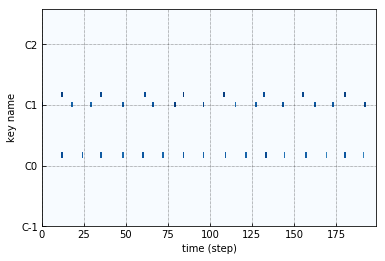

In [158]:
mid.tracks[0].plot()
plt.ylim(12, 55)
plt.xlim(0, 199)

In [180]:
import glob

root_dir = './_drums_midis/Groove Monkee - MIDI Drum Loops/Groove.Monkee.Metal.1.MIDI.Drum.Loops.PC.MAC.SCD-BX8'

def search_folder_for_file_format(folder_path, file_format=r'\.rar$'):
    res = []
    for file in glob.iglob(folder_path + '**/*', recursive=True):
        if re.search(file_format, file) is not None:
            res.append(file)
    return res

rars = search_folder_for_file_format(root_dir)

In [183]:
from pyunpack import Archive
import os

arch = Archive(rars[0])

tmp_path = os.path.join(root_dir, 'tmp')

try:
    os.mkdir(tmp_path)
except FileExistsError:
    pass

arch.extractall(tmp_path)

zips = search_folder_for_file_format(tmp_path, r'\_supplemental.zip$')


['./_drums_midis/Groove Monkee - MIDI Drum Loops/Groove.Monkee.Metal.1.MIDI.Drum.Loops.PC.MAC.SCD-BX8\\tmp\\groove_monkee_metal_supplemental.zip']

In [215]:
def load_midi_files(root_path):
    res = []
    # walk recursively over root_path
    for file in tqdm(glob.iglob(root_path + '**/*', recursive=True)):
        # find midi files(.mid)
        if re.search(r'\.mid$', file) is not None:
            res.append(
                dict(midi=Multitrack(file), file_path=file)
            )
    return res

midis = load_midi_files('./_datasets/')

In [223]:
for midi_mtrack in midis:
    track = midi_mtrack['midi'].tracks[0]
    file = midi_mtrack['file_path']
    break

In [225]:
notes_used_in_track(track, midi_map)

{36: 'Kick',
 38: 'Snare Open Hit L',
 45: 'Ride Pearl (double)',
 58: 'HH Open Bell',
 61: 'Ride Bell',
 67: 'Tom 3'}

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x268effe86a0>)

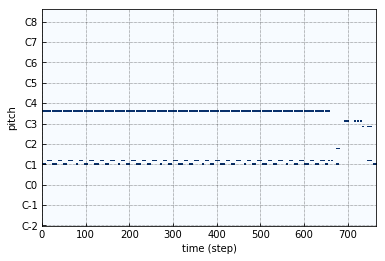

In [250]:
track.plot()

In [295]:
def collapse_index_range(drum_ranges):
    idx = []
    for indecies in drum_ranges:
        if len(indecies) == 1:
            idx.append(indecies[0])
        else:
            idx += list(range(*indecies))
    return idx

def binarize_array(arr):
    return (arr > 0) * 1

def track_to_learn_seq(track, learning_map:'{key: {encoding=drum_range, decoding=drum}}'):
    track.binarize()
    track.trim_trailing_silence()
    
    seq = [0] * len(learning_map.keys())
    for key, drum_ranges in learning_map.items():
        idx = collapse_index_range(drum_ranges['encoding'])
        pre_collapsed_drum_lines = track.pianoroll[:, idx]
        collapsed_drum_lines = np.sum(pre_collapsed_drum_lines, axis=1)
        collapsed_drum_lines = binarize_array(collapsed_drum_lines)
        seq[key] = collapsed_drum_lines
    
    return np.array(seq)

LEARNING_DRUM_MAP = {
    0: dict(
        encoding=[[36]], #kick
        decoding=36,
    ),
    1:  dict(
        encoding=[[37, 44]], # snares
        decoding=38,
    ),
    2: dict(
        encoding=[[47, 63], [75, 82]], # cymbals
        decoding=54,
    ),
    3: dict(
        encoding=[[65, 72]], # toms
        decoding=65,
    ),
}
        
seq = track_to_learn_seq(track, LEARNING_DRUM_MAP)

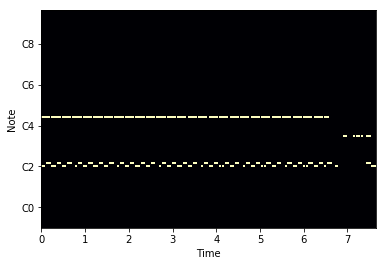

In [316]:
def learn_seq_to_midi(seq, learning_map):
    res = np.zeros([seq.shape[1], 128])
    seq = seq.T
    
    for drum_num, (coding, drum_coding) in zip(range(seq.shape[0]), learning_map.items()):
        res[:, drum_coding['decoding']] = seq[:, drum_num]
    
    return res

track = Track(pianoroll=learn_seq_to_midi(seq, LEARNING_DRUM_MAP), program=0, is_drum=True)
plot_piano_roll(track, 0, track.pianoroll.shape[0])